In [20]:
from mnist_generator import TiledMNISTDataset, label_to_index, index_to_label, collate_fn
import torch
from torch import nn
from torch.nn import functional as F
from torch.utils.data import DataLoader
from torch.nn.utils.rnn import pad_sequence
import matplotlib.pyplot as plt
from torchvision.transforms.functional import to_pil_image
from time import time

ARCHITECTURE

In [21]:
# Patch settings
PATCH_SIZE = 14  # mnist imgs are 56x56 pixels and one patch size is 14x14=196pixels
assert 56 % PATCH_SIZE == 0
NUM_PATCHES = (56 // PATCH_SIZE)**2  # 16 patches

# Channel, Embedding and Token Count, Context size
CHANNELS = 1  # grayscale -> equals to 1 channels which is used for setting up the Conv2D-based patch projector
CONTEXT_SIZE = 6  # what is the maximum context length for predictions #start 4 digits end
N_EMBD = 64

# Transformer block+dropout
NUM_BLOCKS = 4
DROPOUT = 0.1
NUM_HEADS = 4

# Training
BATCH_SIZE = 64  # how many independent sequences will we process in parallel?
NUM_EPOCHS = 5
LEARNING_RATE = 3e-4
WEIGHT_DECAY = 0.1
LEARNING_RATE_DECAY = 0.9
train = True

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

Load the dataset

In [23]:

train_dataset = TiledMNISTDataset(split="train", allow_blanks=True)
test_dataset = TiledMNISTDataset(split="test",allow_blanks=True)

Create data loaders

In [24]:
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE,
                          shuffle=True, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE,
                         shuffle=False, collate_fn=collate_fn)

Visualise tokens and image

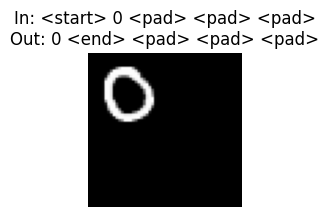

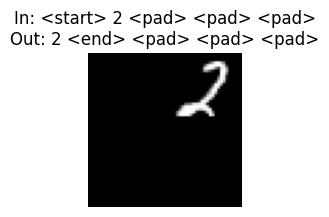

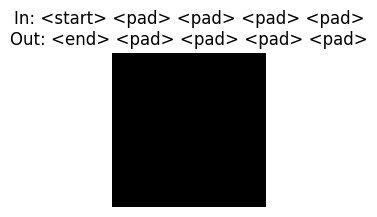

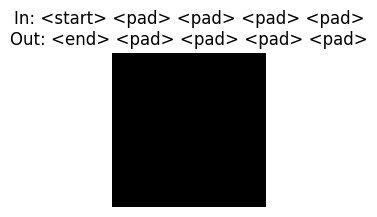

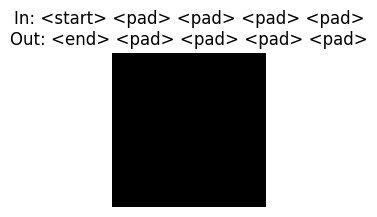

torch.Size([64, 1, 56, 56])

In [25]:
batch = next(iter(train_loader))
images, in_seqs, out_seqs = batch

for i in range(5):
    img = images[i].squeeze()
    input_tokens = [index_to_label[idx.item()] for idx in in_seqs[i]]
    target_tokens = [index_to_label[idx.item()] for idx in out_seqs[i]]

    plt.figure(figsize=(2, 2))
    plt.imshow(img, cmap="gray")
    plt.axis("off")
    plt.title(f"In: {' '.join(input_tokens)}\nOut: {' '.join(target_tokens)}")
    plt.show()

images.shape

In [12]:
# Image size (tiled) = 1 x 56 x 56 (2 x 2 grid)
# Encoder input shape = (B, 1, 56, 56)
# Patch size = 14 x 14
# Number of patches = 16
# Decoder input shape = (B, T) where B-batch_size and T = max sequence lenghth in batch
# Target shape = (B, T)
# Vocab size = 13
# Special tokens = <start> <end><pad>
# Padding value 12 <pad>
# Max digits per image 4
# Max sequnce length 6 (<start> d1 d2 d3 d4 <end>)

Patch Embeddings

In [26]:
class PatchEmbedding(nn.Module):
    def __init__(self):
        super().__init__()
        # example Input of Raw MNIST images (Batch_size=32, Chanel=1, W=56, h=56)
        self._conv2d = nn.Conv2d(
            in_channels=CHANNELS,  # channel=1
            out_channels=N_EMBD,  # n_embd=64 - the dimensional embedding vector
            kernel_size=PATCH_SIZE,  # defines the size of each patch 14x14
            # moves the kernel by 14 pixels = no overlap between patches
            stride=PATCH_SIZE, padding=0)
        # after conv2d each of 16 patches (4x4gid) mapped to 64 features (nr of embeddings)=> (Batch size=32, Emb=64, 4, 4)
        # Flattens [B, 64, 4, 4] → [B, 64, 16]
        self._flatten = nn.Flatten(start_dim=2, end_dim=3)

    def forward(self, x):
        x = self._conv2d(x)  # (B, 1,56,56)->(B,64,4,4)
        x = self._flatten(x)  # -> (B, 64, 16)
        # after permuting the (32,64,4,4) we have (32=Batch,16=patches,64=embedning vector in embedding space) = > Final ViT input: token sequence
        return x.permute(0, 2, 1)  # (B, 16, 16

Test patching embedding

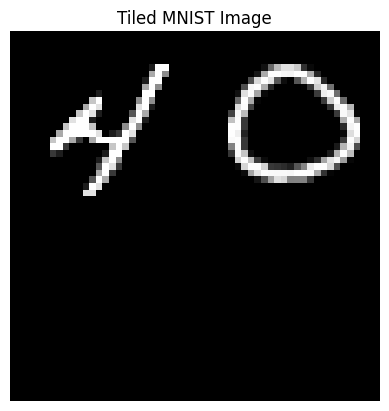

Patch Embedding Output Shape: torch.Size([1, 16, 64])

Patch 0 (Shape: torch.Size([64]) ):
 tensor([ 0.2262,  0.1680, -0.1309,  0.0450, -0.0451,  0.1741, -0.0306,  0.1999,
         0.0035,  0.0835, -0.0051,  0.1489,  0.0646, -0.0702,  0.1411,  0.1112,
        -0.1169,  0.1801,  0.0971,  0.0031, -0.0879, -0.2611, -0.1295,  0.0771,
        -0.0745, -0.1509, -0.0196,  0.1828,  0.2894, -0.0006, -0.1165, -0.1459,
        -0.0101,  0.1517,  0.0556, -0.0116,  0.3409,  0.0399,  0.1358,  0.0607,
        -0.1090,  0.1356,  0.0242,  0.0690, -0.0594, -0.2971,  0.0057,  0.1769,
         0.1625,  0.1059, -0.0185, -0.1170,  0.1660, -0.1564,  0.1590, -0.1460,
         0.2737, -0.1752,  0.1302, -0.0544,  0.0128, -0.0240, -0.2553,  0.1273],
       grad_fn=<SelectBackward0>)

Patch 1 (Shape: torch.Size([64]) ):
 tensor([ 8.2970e-02, -5.1879e-02, -2.7361e-02, -3.3736e-01,  8.9571e-02,
        -7.8755e-02,  3.8360e-04,  6.0220e-02, -1.6631e-01,  5.5495e-02,
         1.4310e-01, -6.2107e-02, -1.5611e-01, -3

In [27]:
# initialize the patch emebeding module
patch_embed = PatchEmbedding()

# Get a single sample (image, input_seq, target_seq)
image, input_seq, target_seq = train_dataset[0]  # image shape: (1, 56, 56)

plt.imshow(image.squeeze(), cmap="gray")
plt.axis("off")
plt.title("Tiled MNIST Image")
plt.show()

# Add batch dimension: shape (1, 1, 56, 56)
image = image.unsqueeze(0)

# Initialize the patch embedding module
patch_embed = PatchEmbedding()

# Get patch embeddings
patches = patch_embed(image)  # shape: (1, 16, 64)

print("Patch Embedding Output Shape:", patches.shape)
# Expecting: torch.Size([1, 16, 64])
patch_0 = patches[0, 0]  # First patch in the sequence
patch_1 = patches[0, 1]  # Second patch

print("\nPatch 0 (Shape:", patch_0.shape, "):\n", patch_0)
print("\nPatch 1 (Shape:", patch_1.shape, "):\n", patch_1)

SELF-ATTENTION CLASS

In [28]:
class AttentionHead(nn.Module):  # Head
    """ one head of self-attention """
    # Constructor

    def __init__(self, head_size, is_decoder):
        super().__init__()
        self.key = nn.Linear(N_EMBD, head_size, bias=False)
        self.query = nn.Linear(N_EMBD, head_size, bias=False)
        self.value = nn.Linear(N_EMBD, head_size, bias=False)
        self.register_buffer('tril', torch.tril(  # trils is a lower triangular matrix used for masking future tokens in decoder self-attebtion, not needed in Vit or encoder
            torch.ones(CONTEXT_SIZE, CONTEXT_SIZE)))  # shape is T, T
        self.dropout = nn.Dropout(DROPOUT)
        self._is_decoder = is_decoder

    def forward(self, x):
        B, T, C = x.shape
        k = self.key(x)   # SHAPE(B T C)
        q = self.query(x)  # SHAPE(B T C)s
        wei = q @ k.transpose(-2, -1) * C**-0.5
        if self._is_decoder:  # only in decoder blocks
            wei = wei.masked_fill(
                self.tril[:T, :T] == 0, float('-inf'))  # (B, T, T)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)
        v = self.value(x)
        out = wei @ v
        return out  # (B, T, head_size)

MULTI-HEAD ATTENTION CLASS

In [29]:
# 4 heads where the head size per head is 16 (Embed dim/num of heads)
class MultiHeadAttention(nn.Module):
    """ multiple heads of self-attention in parallel """

    def __init__(self, head_size, is_decoder=True):
        super().__init__()

        self.heads = nn.ModuleList(
            [AttentionHead(head_size, is_decoder) for _ in range(NUM_HEADS)])
        self.proj = nn.Linear(head_size * NUM_HEADS, N_EMBD)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, x):

        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

Cross Attention Head

In [30]:
class CrossAttentionHead(nn.Module):
    """ One head of cross-attention """

    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(N_EMBD, head_size, bias=False)
        self.query = nn.Linear(N_EMBD, head_size, bias=False)
        self.value = nn.Linear(N_EMBD, head_size, bias=False)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, query_input, encoder_output):
        """
        query_input: shape (B, T_dec, N_EMBD) ← decoder input
        encoder_output: shape (B, T_enc, N_EMBD) ← encoder output (patch tokens)
        """
        B, T_dec, _ = query_input.shape
        T_enc = encoder_output.size(1)

        k = self.key(encoder_output)       # (B, T_enc, head_size)
        q = self.query(query_input)        # (B, T_dec, head_size)
        v = self.value(encoder_output)     # (B, T_enc, head_size)

        # Attention scores
        wei = q @ k.transpose(-2, -1) * (k.size(-1)
                                         ** -0.5)  # (B, T_dec, T_enc)
        wei = F.softmax(wei, dim=-1)
        wei = self.dropout(wei)

        # Weighted sum of values
        out = wei @ v  # (B, T_dec, head_size)
        return out

MULTI_CROSS ATTENTION HEAD

In [31]:
class MultiHeadCrossAttention(nn.Module):
    """ Multi-head cross-attention for decoder """

    def __init__(self, head_size):
        super().__init__()
        self.heads = nn.ModuleList([
            CrossAttentionHead(head_size) for _ in range(NUM_HEADS)
        ])
        self.proj = nn.Linear(head_size * NUM_HEADS, N_EMBD)
        self.dropout = nn.Dropout(DROPOUT)

    def forward(self, query_input, encoder_output):
        # Each head processes the inputs in parallel
        out = torch.cat([h(query_input, encoder_output)
                        for h in self.heads], dim=-1)
        out = self.proj(out)
        out = self.dropout(out)
        return out

In [32]:
class MLP(nn.Module):  # FeedForward where clasification takes place
    """ a simple linear layer followed by a non-linearity """

    def __init__(self):
        super().__init__()
        self.net = nn.Sequential(
            # first fully connected layer. Expands the feature space (eg from 64 to 256) allowing the network to learn more complex intermediate represenations
            nn.Linear(N_EMBD, 4 * N_EMBD),
            nn.GELU(),  # ViT paper uses GELU # Activation fuctions -Adds non-linearity
            # Projects back down to original embedding dim eg 256 ->64
            nn.Linear(4 * N_EMBD, N_EMBD),
            nn.Dropout(DROPOUT),
        )

    def forward(self, x):
        # passes the input x of shape B x T x N-Embed through the MLP block. Output has the same shape
        return self.net(x)

SELF ATTENTION BLOCK

In [ ]:
class SelfAttentionBlock(nn.Module):
    def __init__(self, is_decoder=False):
        super().__init__()
        head_size = N_EMBD//NUM_HEADS
        self.attn = MultiHeadAttention(head_size, is_decoder=is_decoder)
        self.mlp = MLP()
        self.ln1 = nn.LayerNorm(N_EMBD)
        self.ln2 = nn.LayerNorm(N_EMBD)

    def forward(self, x):
        x = x+self.attn(self.ln1(x))
        x = x+self.mlp(self.ln2(x))
        return x

CROSS-ATTENTION BLOCK

In [34]:
class CrossAttentionBlock(nn.Module):
    def __init__(self):
        super().__init__()
        head_size = N_EMBD // NUM_HEADS
        self.cross_attn = MultiHeadCrossAttention(head_size)
        self.mlp = MLP()
        self.ln1 = nn.LayerNorm(N_EMBD)
        self.ln2 = nn.LayerNorm(N_EMBD)

    def forward(self, x, encoder_output):
        x = x + self.cross_attn(self.ln1(x), encoder_output)
        x = x + self.mlp(self.ln2(x))
        return x

ENCODER

In [35]:
class TransformerEncoder(nn.Module):
    def __init__(self):
        super().__init__()
        self.patch_embed = PatchEmbedding()  # outputs (B, 16, 64)
        self.pos_embed = nn.Parameter(torch.randn(
            1, NUM_PATCHES, N_EMBD))  # (1, 16, 64)

        self.blocks = nn.Sequential(
            *[SelfAttentionBlock(is_decoder=False) for _ in range(NUM_BLOCKS)]
        )
        self.ln_final = nn.LayerNorm(N_EMBD)

    def forward(self, x):
        x = self.patch_embed(x)  # (B, 16, 64)
        x = x + self.pos_embed   # Add positional encoding
        x = self.blocks(x)       # Apply transformer encoder blocks
        x = self.ln_final(x)
        return x  # (B, 16, 64)

DECODER

In [36]:
class TransformerDecoder(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embed = nn.Embedding(vocab_size, N_EMBD)
        self.pos_embed = nn.Embedding(CONTEXT_SIZE, N_EMBD)

        self.blocks = nn.ModuleList([
            nn.Sequential(
                SelfAttentionBlock(is_decoder=True),
                CrossAttentionBlock()
            ) for _ in range(NUM_BLOCKS)
        ])

        self.ln_final = nn.LayerNorm(N_EMBD)
        self.output_layer = nn.Linear(N_EMBD, vocab_size)

    def forward(self, x, encoder_output):
        B, T = x.shape
        token_embeddings = self.token_embed(x)  # (B, T, 64)
        positions = torch.arange(T, device=x.device).unsqueeze(0)
        position_embeddings = self.pos_embed(positions)  # (1, T, 64)
        x = token_embeddings + position_embeddings

        for block in self.blocks:
            self_attn, cross_attn = block
            x = self_attn(x)
            x = cross_attn(x, encoder_output)

        x = self.ln_final(x)
        logits = self.output_layer(x)  # (B, T, vocab_size)
        return logits

TRANSFORMER

In [37]:
class TransformerMNIST(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.encoder = TransformerEncoder()
        self.decoder = TransformerDecoder(vocab_size)

    def forward(self, image, input_seq):
        encoder_output = self.encoder(image)  # (B, 16, 64)
        logits = self.decoder(input_seq, encoder_output)  # (B, T, vocab_size)
        return logits

In [38]:
model = TransformerMNIST(vocab_size=13)
image, in_seq, target_seq = train_dataset[0]
image = image.unsqueeze(0)         # (1, 1, 56, 56)
in_seq = in_seq.unsqueeze(0)       # (1, T)

logits = model(image, in_seq)      # (1, T, vocab_size)
print(logits.shape)

TypeError: layer_norm(): argument 'input' (position 1) must be Tensor, not NoneType